<a href="https://colab.research.google.com/github/R-Meister/GradGuide/blob/main/BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
# Module 1: Data Ingestion & ETL
This notebook handles loading raw weather data from CSV into Spark, performing basic cleaning,
and writing to Delta Lake Bronze tables with proper partitioning.


# Install required packages for Google Colab
!pip install pyspark==3.4.0 delta-spark==2.4.0 pyarrow
"""
# Import necessary libraries
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType
from datetime import datetime

# Create a Spark session with Delta Lake support
def create_spark_session():
    """Create and return a Spark session with Delta Lake support."""
    spark = SparkSession.builder \
        .appName("Weather Data Processing") \
        .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

    # For Google Colab, display Spark UI link
    try:
        from google.colab import output
        display(output.serve_kernel_port_as_window(spark.sparkContext.uiWebUrl))
        print(f"Spark Web UI available at: {spark.sparkContext.uiWebUrl}")
    except:
        print("Spark UI link not available")

    return spark

# Function to check for the sample data and provide file upload in Colab
def check_for_data():
    """Check if the dataset exists and provide file upload widget in Colab."""
    dataset_path = '/content/GlobalLandTemperaturesByCity.csv'

    if not os.path.exists(dataset_path):
        print(f"\nDATA FILE NOT FOUND: '{dataset_path}'")
        print("\nPlease upload the dataset using the file upload widget below:")

        # For Google Colab, provide file upload widgets
        from google.colab import files
        print("\nUploading file through Colab interface...")
        uploaded = files.upload()

        # Check for correct file upload
        if 'GlobalLandTemperaturesByCity.csv' in uploaded:
            print("Upload complete! Dataset is now available.")
            return True
        else:
            print("Required file not uploaded. Please upload 'GlobalLandTemperaturesByCity.csv'.")
            return False
    else:
        print(f"Dataset found: '{dataset_path}'")
        return True

# Define schema for the CSV file
def define_schema():
    """Define and return the schema for the weather data."""
    schema = StructType([
        StructField("dt", StringType(), True),
        StructField("AverageTemperature", DoubleType(), True),
        StructField("AverageTemperatureUncertainty", DoubleType(), True),
        StructField("City", StringType(), True),
        StructField("Country", StringType(), True),
        StructField("Latitude", StringType(), True),
        StructField("Longitude", StringType(), True)
    ])
    return schema

# Load data with the defined schema
def load_data(spark, schema):
    """Load data from CSV file using the provided schema."""
    df = spark.read.format("csv") \
        .option("header", "true") \
        .option("mode", "DROPMALFORMED") \
        .schema(schema) \
        .load("GlobalLandTemperaturesByCity.csv")

    return df

# Basic cleaning and transformation
def clean_data(df):
    """Perform basic cleaning and transformation of the data."""
    # Convert date string to date type
    df = df.withColumn("dt", F.to_date(F.col("dt")))

    # Extract year and month for partitioning
    df = df.withColumn("year", F.year(F.col("dt")))
    df = df.withColumn("month", F.month(F.col("dt")))

    # Handle missing values - replace nulls with mean for numeric columns
    # First check if there are actually missing values
    missing_temp = df.filter(F.col("AverageTemperature").isNull()).count()
    missing_uncertainty = df.filter(F.col("AverageTemperatureUncertainty").isNull()).count()

    print(f"Missing values found - AverageTemperature: {missing_temp}, AverageTemperatureUncertainty: {missing_uncertainty}")

    if missing_temp > 0 or missing_uncertainty > 0:
        # Calculate means only if there are missing values
        avg_temp = df.filter(F.col("AverageTemperature").isNotNull()) \
                     .select(F.avg("AverageTemperature").alias("avg_temp")) \
                     .collect()[0]["avg_temp"]

        avg_uncertainty = df.filter(F.col("AverageTemperatureUncertainty").isNotNull()) \
                            .select(F.avg("AverageTemperatureUncertainty").alias("avg_uncertainty")) \
                            .collect()[0]["avg_uncertainty"]

        print(f"Using mean values - Temperature: {avg_temp:.2f}, Uncertainty: {avg_uncertainty:.2f}")

        # Fill missing values with means
        df = df.fillna({
            "AverageTemperature": avg_temp,
            "AverageTemperatureUncertainty": avg_uncertainty
        })

    # Clean City and Country fields (trim whitespace, convert to uppercase)
    df = df.withColumn("City", F.trim(F.upper(F.col("City"))))
    df = df.withColumn("Country", F.trim(F.upper(F.col("Country"))))

    return df

# Write to Delta Lake Bronze table with fallback to Parquet
def write_to_bronze(df):
    """Write the dataframe to a Delta Lake Bronze table with partitioning."""
    # Create a directory for our Delta tables if it doesn't exist
    bronze_path = "delta_lake/bronze/weather_data"

    try:
        # Write to Delta table partitioned by year and month
        df.write \
            .format("delta") \
            .partitionBy("year", "month") \
            .mode("overwrite") \
            .save(bronze_path)

        print(f"Data written to Delta Lake Bronze table at {bronze_path}")
        return bronze_path, "delta"
    except Exception as e:
        print(f"Error writing to Delta table: {str(e)}")
        print("Falling back to Parquet format...")

        # Fallback to Parquet if Delta fails
        parquet_path = "parquet_data/bronze/weather_data"
        df.write \
            .format("parquet") \
            .partitionBy("year", "month") \
            .mode("overwrite") \
            .save(parquet_path)

        print(f"Data written to Parquet files at {parquet_path}")
        return parquet_path, "parquet"

# Create a simple logging function
def log_process(message):
    """Log processing information with timestamp."""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {message}")

# Main ETL process
def run_etl_process():
    """Run the full ETL process."""
    log_process("Starting ETL process")

    # Make sure data is available
    data_available = check_for_data()
    if not data_available:
        raise Exception("Data file not found. Please upload the dataset and try again.")

    # Initialize Spark
    log_process("Initializing Spark session with Delta Lake support")
    spark = create_spark_session()

    # Print Spark version info
    spark_version = spark.version
    log_process(f"Using Apache Spark version: {spark_version}")

    # Define schema and load data
    log_process("Loading data from CSV")
    schema = define_schema()
    raw_df = load_data(spark, schema)

    # Print initial stats
    record_count = raw_df.count()
    log_process(f"Loaded {record_count} records")
    log_process("Sample of raw data:")
    raw_df.show(5)

    # Data quality check - check for missing values in important columns
    missing_data = {}
    for col in raw_df.columns:
        missing_count = raw_df.filter(F.col(col).isNull()).count()
        if missing_count > 0:
            missing_data[col] = missing_count

    if missing_data:
        log_process("Missing data found in the following columns:")
        for col, count in missing_data.items():
            print(f"  - {col}: {count} missing values ({(count/record_count)*100:.2f}%)")
    else:
        log_process("No missing values found in the dataset")

    # Clean data
    log_process("Cleaning and transforming data")
    clean_df = clean_data(raw_df)

    # Print cleaned data stats
    log_process("Sample of cleaned data:")
    clean_df.show(5)

    # Write to Delta Lake/Parquet
    log_process("Writing to storage")
    bronze_path, format_used = write_to_bronze(clean_df)

    # Verify data in storage
    log_process(f"Verifying data in {format_used.upper()} storage")
    try:
        if format_used == "delta":
            bronze_df = spark.read.format("delta").load(bronze_path)
        else:
            bronze_df = spark.read.format("parquet").load(bronze_path)

        bronze_count = bronze_df.count()
        log_process(f"Bronze table record count: {bronze_count} (using {format_used.upper()})")

        # Verify record counts match
        if bronze_count != record_count:
            log_process(f"WARNING: Record count mismatch! Original: {record_count}, Bronze: {bronze_count}")
        else:
            log_process(f"Data integrity verified: {bronze_count} records successfully written")

        # Display partitioning information
        log_process("Partitioning information (sample):")
        bronze_df.groupBy("year", "month").count().orderBy("year", "month").show(10)

    except Exception as e:
        log_process(f"ERROR verifying data: {str(e)}")

    log_process("ETL process completed successfully")

    return spark, bronze_df

# Run the ETL process if this notebook is executed directly
if __name__ == "__main__":
    try:
        spark, bronze_df = run_etl_process()
        print("\nETL process executed successfully!")
        print("You can now use 'spark' and 'bronze_df' variables in subsequent cells.")
    except Exception as e:
        import traceback
        print(f"\nERROR: ETL process failed with error: {str(e)}")
        traceback.print_exc()
        print("\nTroubleshooting tips:")
        print("1. Ensure you've uploaded the globallandtemperaturesbycity.csv file")
        print("2. Check that all required packages are installed correctly")
        print("3. Restart the runtime if experiencing memory issues")
        print("4. Check for errors in the Spark UI")

[2025-05-06 12:23:56] Starting ETL process
Dataset found: '/content/GlobalLandTemperaturesByCity.csv'
[2025-05-06 12:23:56] Initializing Spark session with Delta Lake support
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

None

Spark Web UI available at: http://595cb6717a02:4040
[2025-05-06 12:23:56] Using Apache Spark version: 3.4.0
[2025-05-06 12:23:56] Loading data from CSV
[2025-05-06 12:24:05] Loaded 1048575 records
[2025-05-06 12:24:05] Sample of raw data:
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|                        1.737|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+

[2025-05-06 13:04:37] Starting EDA and Cleaning process
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

None

Spark Web UI available at: http://595cb6717a02:4040
[2025-05-06 13:04:37] Loading data from Delta Lake Bronze table
[2025-05-06 13:04:38] Loaded 1048575 records from Delta Lake
[2025-05-06 13:04:38] Registered temp view: weather_data
[2025-05-06 13:04:38] Calculating summary statistics

=== SUMMARY STATISTICS ===
+-------+------------------+-----------------------------+--------+-----------+--------+---------+------------------+------------------+
|summary|AverageTemperature|AverageTemperatureUncertainty|    City|    Country|Latitude|Longitude|              year|             month|
+-------+------------------+-----------------------------+--------+-----------+--------+---------+------------------+------------------+
|  count|           1048575|                      1048575| 1048575|    1048575| 1048575|  1048575|            472545|            472545|
|   mean|17.928990675585577|           1.0338311785484533|    null|       null|    null|     null|1845.5741252155879| 6.503645155487837|


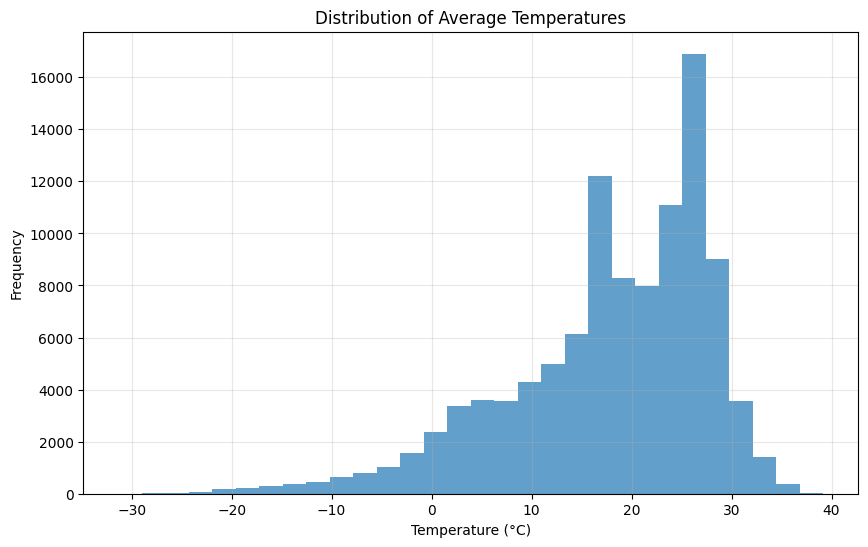

[2025-05-06 13:06:35] Detecting outliers

=== OUTLIER DETECTION ===
[2025-05-06 13:06:42] Temperature bounds for outliers: -12.43°C to 48.29°C
[2025-05-06 13:06:47] Found 12076 outliers (1.15% of data)
[2025-05-06 13:06:47] Sample of outlier records:
+----------+------------------+-----------------------------+---------------+-------+--------+---------+----+-----+
|        dt|AverageTemperature|AverageTemperatureUncertainty|           City|Country|Latitude|Longitude|year|month|
+----------+------------------+-----------------------------+---------------+-------+--------+---------+----+-----+
|      null|           -31.874|                         0.46|BLAGOVESHCHENSK| RUSSIA|  50.63N|  128.03E|null| null|
|1861-01-01|           -31.473|                        5.872|BLAGOVESHCHENSK| RUSSIA|  50.63N|  128.03E|1861|    1|
|      null|           -31.312|                         0.63|        BARNAUL| RUSSIA|  53.84N|   83.18E|null| null|
|1893-01-01|           -31.138|                      

In [3]:
"""
# Module 2: EDA & Cleaning
This notebook performs exploratory data analysis on the weather data, including summary statistics,
distributions, missing value analysis, and creates a cleaned Delta Silver table.
"""

# Install packages if not already installed
try:
    import pyspark
    import delta
except ImportError:
    !pip install pyspark==3.4.0 delta-spark==2.4.0 pyarrow matplotlib seaborn

# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql.functions import col, count, isnan, when, isnull, year, month, expr

# Create a Spark session with Delta Lake support
def create_spark_session():
    """Create and return a Spark session with Delta Lake support."""
    spark = SparkSession.builder \
        .appName("Weather Data EDA & Cleaning") \
        .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

    # For Google Colab, display Spark UI link
    try:
        from google.colab import output
        display(output.serve_kernel_port_as_window(spark.sparkContext.uiWebUrl))
        print(f"Spark Web UI available at: {spark.sparkContext.uiWebUrl}")
    except:
        print("Spark UI link not available")

    return spark

# Create a simple logging function
def log_process(message):
    """Log processing information with timestamp."""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {message}")

# Check if the bronze table exists
def load_bronze_data(spark, bronze_path="delta_lake/bronze/weather_data", fallback_path="parquet_data/bronze/weather_data"):
    """Load data from the bronze Delta table or fallback to parquet if needed."""
    try:
        # Try loading from Delta first
        log_process("Loading data from Delta Lake Bronze table")
        df = spark.read.format("delta").load(bronze_path)
        format_used = "Delta Lake"
    except Exception as e:
        print(f"Error loading Delta table: {str(e)}")
        print("Falling back to Parquet format...")

        # Fallback to Parquet
        df = spark.read.format("parquet").load(fallback_path)
        format_used = "Parquet"

    log_process(f"Loaded {df.count()} records from {format_used}")
    return df

# Function to register a table for SQL queries
def register_temp_view(df, view_name="weather_data"):
    """Register the dataframe as a temporary view for SQL queries."""
    df.createOrReplaceTempView(view_name)
    log_process(f"Registered temp view: {view_name}")
    return view_name

# Function to perform basic summary statistics
def summary_statistics(df):
    """Calculate and display summary statistics for numeric columns."""
    log_process("Calculating summary statistics")

    # Overall summary statistics
    print("\n=== SUMMARY STATISTICS ===")
    df.describe().show()

    # Count of records by year (sample)
    log_process("Records by Year (Top 10):")
    df.groupBy("year").count().orderBy("year").show(10)

    # Count of records by country (top 10)
    log_process("Records by Country (Top 10):")
    df.groupBy("Country").count().orderBy(F.desc("count")).show(10)

    # Temperature statistics by year (sample)
    log_process("Temperature by Year (sample):")
    df.groupBy("year") \
      .agg(
          F.round(F.avg("AverageTemperature"), 2).alias("avg_temp"),
          F.round(F.min("AverageTemperature"), 2).alias("min_temp"),
          F.round(F.max("AverageTemperature"), 2).alias("max_temp"),
          F.round(F.stddev("AverageTemperature"), 2).alias("stddev_temp")
      ) \
      .orderBy("year").show(10)

    return df

# Function to analyze missing values
def missing_value_analysis(df, spark):
    """Analyze missing values in the dataset."""
    log_process("Analyzing missing values")

    # Count missing values in each column
    print("\n=== MISSING VALUE ANALYSIS ===")

    # Create a dataframe with missing value counts and percentages
    missing_counts = []
    for col_name in df.columns:
        missing_count = df.filter(col(col_name).isNull()).count()
        total_count = df.count()
        missing_pct = (missing_count / total_count) * 100
        missing_counts.append((col_name, missing_count, missing_pct))

    # Convert to a Spark DataFrame
    missing_df = spark.createDataFrame(missing_counts, ["column_name", "missing_count", "missing_percentage"])
    missing_df.show()

    # Analyze missing temperature values by year
    log_process("Missing temperature values by year (sample):")
    df.groupBy("year") \
      .agg((F.sum(F.when(F.col("AverageTemperature").isNull(), 1).otherwise(0))).alias("missing_temp_count"),
           F.count("*").alias("total_count")) \
      .withColumn("missing_percentage", F.round((F.col("missing_temp_count") / F.col("total_count")) * 100, 2)) \
      .orderBy("year").show(10)

    return missing_df

# Function for distribution analysis
def distribution_analysis(df):
    """Analyze distributions of key columns."""
    log_process("Analyzing distributions")

    print("\n=== DISTRIBUTION ANALYSIS ===")

    # Temperature distribution
    log_process("Temperature Distribution:")
    temp_buckets = df.select(
        F.when(col("AverageTemperature") < 0, "Below 0°C")
         .when(col("AverageTemperature").between(0, 10), "0-10°C")
         .when(col("AverageTemperature").between(10, 20), "10-20°C")
         .when(col("AverageTemperature").between(20, 30), "20-30°C")
         .when(col("AverageTemperature") >= 30, "30°C and above")
         .otherwise("Unknown").alias("temp_range")
    )

    # Count by temperature range
    temp_buckets.groupBy("temp_range").count().orderBy("temp_range").show()

    # Distribution by decades
    log_process("Distribution by Decades:")
    df.withColumn("decade", (F.floor(col("year") / 10) * 10).cast("int")) \
      .groupBy("decade") \
      .count() \
      .orderBy("decade") \
      .show(20)

    # Show record counts by month
    log_process("Record distribution by month:")
    df.groupBy("month") \
      .agg(F.count("*").alias("count"),
           F.round(F.avg("AverageTemperature"), 2).alias("avg_temp")) \
      .orderBy("month") \
      .show()

    # Convert small sample to Pandas for histogram
    log_process("Creating temperature histogram (sample data):")
    sample_pd = df.select("AverageTemperature").sample(False, 0.1).toPandas()

    plt.figure(figsize=(10, 6))
    plt.hist(sample_pd["AverageTemperature"], bins=30, alpha=0.7)
    plt.title("Distribution of Average Temperatures")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()

    return temp_buckets

# Function for outlier detection
def detect_outliers(df):
    """Detect outliers in the temperature data."""
    log_process("Detecting outliers")

    print("\n=== OUTLIER DETECTION ===")

    # Calculate statistics for outlier detection
    temp_stats = df.select(
        F.mean("AverageTemperature").alias("mean"),
        F.stddev("AverageTemperature").alias("stddev")
    ).collect()[0]

    mean_temp = temp_stats["mean"]
    stddev_temp = temp_stats["stddev"]

    # Define outlier thresholds (3 standard deviations)
    lower_bound = mean_temp - 3 * stddev_temp
    upper_bound = mean_temp + 3 * stddev_temp

    log_process(f"Temperature bounds for outliers: {lower_bound:.2f}°C to {upper_bound:.2f}°C")

    # Identify outliers
    outliers = df.filter((col("AverageTemperature") < lower_bound) |
                         (col("AverageTemperature") > upper_bound))

    outlier_count = outliers.count()
    total_count = df.count()
    outlier_percentage = (outlier_count / total_count) * 100

    log_process(f"Found {outlier_count} outliers ({outlier_percentage:.2f}% of data)")

    # Show some example outliers
    log_process("Sample of outlier records:")
    outliers.orderBy(col("AverageTemperature")).show(5)
    outliers.orderBy(col("AverageTemperature").desc()).show(5)

    return outliers

# Function for SQL analysis
def sql_analysis(spark, view_name):
    """Perform analysis using Spark SQL."""
    log_process("Performing SQL analysis")

    print("\n=== SQL ANALYSIS ===")

    # Average temperature by continent (simplified approach)
    log_process("Average temperature by continent:")
    continent_query = """
    SELECT
        CASE
            WHEN Country IN ('UNITED STATES', 'CANADA', 'MEXICO') THEN 'North America'
            WHEN Country IN ('BRAZIL', 'ARGENTINA', 'CHILE', 'COLOMBIA', 'PERU', 'VENEZUELA', 'ECUADOR') THEN 'South America'
            WHEN Country IN ('CHINA', 'INDIA', 'JAPAN', 'KOREA', 'MALAYSIA', 'THAILAND', 'VIETNAM', 'INDONESIA') THEN 'Asia'
            WHEN Country IN ('GERMANY', 'FRANCE', 'UNITED KINGDOM', 'ITALY', 'SPAIN', 'RUSSIA', 'UKRAINE', 'POLAND', 'ROMANIA') THEN 'Europe'
            WHEN Country IN ('AUSTRALIA', 'NEW ZEALAND') THEN 'Oceania'
            WHEN Country IN ('EGYPT', 'SOUTH AFRICA', 'NIGERIA', 'KENYA', 'MOROCCO', 'ALGERIA', 'GHANA') THEN 'Africa'
            ELSE 'Other'
        END AS continent,
        ROUND(AVG(AverageTemperature), 2) AS avg_temp,
        COUNT(*) AS record_count
    FROM weather_data
    GROUP BY continent
    ORDER BY avg_temp DESC
    """
    spark.sql(continent_query).show()

    # Temperature trends over time (by decade)
    log_process("Temperature trends by decade:")
    decade_query = """
    SELECT
        FLOOR(year/10)*10 AS decade,
        ROUND(AVG(AverageTemperature), 2) AS avg_temp,
        ROUND(MIN(AverageTemperature), 2) AS min_temp,
        ROUND(MAX(AverageTemperature), 2) AS max_temp,
        COUNT(*) AS record_count
    FROM weather_data
    GROUP BY FLOOR(year/10)*10
    ORDER BY decade
    """
    spark.sql(decade_query).show()

    # Cities with highest average temperatures
    log_process("Top 10 cities with highest average temperatures:")
    hot_cities_query = """
    SELECT
        City,
        Country,
        ROUND(AVG(AverageTemperature), 2) AS avg_temp,
        COUNT(*) AS record_count
    FROM weather_data
    GROUP BY City, Country
    HAVING COUNT(*) > 100
    ORDER BY avg_temp DESC
    LIMIT 10
    """
    spark.sql(hot_cities_query).show()

    # Cities with lowest average temperatures
    log_process("Top 10 cities with lowest average temperatures:")
    cold_cities_query = """
    SELECT
        City,
        Country,
        ROUND(AVG(AverageTemperature), 2) AS avg_temp,
        COUNT(*) AS record_count
    FROM weather_data
    GROUP BY City, Country
    HAVING COUNT(*) > 100
    ORDER BY avg_temp ASC
    LIMIT 10
    """
    spark.sql(cold_cities_query).show()

    # Seasonal analysis
    log_process("Seasonal temperature analysis:")
    season_query = """
    SELECT
        CASE
            WHEN month IN (12, 1, 2) THEN 'Winter'
            WHEN month IN (3, 4, 5) THEN 'Spring'
            WHEN month IN (6, 7, 8) THEN 'Summer'
            WHEN month IN (9, 10, 11) THEN 'Fall'
        END AS season,
        ROUND(AVG(AverageTemperature), 2) AS avg_temp,
        COUNT(*) AS record_count
    FROM weather_data
    GROUP BY
        CASE
            WHEN month IN (12, 1, 2) THEN 'Winter'
            WHEN month IN (3, 4, 5) THEN 'Spring'
            WHEN month IN (6, 7, 8) THEN 'Summer'
            WHEN month IN (9, 10, 11) THEN 'Fall'
        END
    ORDER BY avg_temp DESC
    """
    spark.sql(season_query).show()

    return True

# Function to clean and prepare data for Silver table
def prepare_silver_data(df):
    """Clean and prepare data for the Silver table."""
    log_process("Preparing data for Silver table")

    # Handle null dates (filter them out)
    cleaned_df = df.filter(col("dt").isNotNull())

    # Convert latitude and longitude to numeric values
    cleaned_df = cleaned_df.withColumn(
        "latitude_numeric",
        F.when(col("Latitude").endswith("N"),
              F.regexp_replace(col("Latitude"), "N", "").cast("float"))
        .when(col("Latitude").endswith("S"),
              F.regexp_replace(col("Latitude"), "S", "").cast("float") * -1)
        .otherwise(None)
    )

    cleaned_df = cleaned_df.withColumn(
        "longitude_numeric",
        F.when(col("Longitude").endswith("E"),
              F.regexp_replace(col("Longitude"), "E", "").cast("float"))
        .when(col("Longitude").endswith("W"),
              F.regexp_replace(col("Longitude"), "W", "").cast("float") * -1)
        .otherwise(None)
    )

    # Filter out records with null or extreme temperatures
    temp_stats = cleaned_df.select(
        F.mean("AverageTemperature").alias("mean"),
        F.stddev("AverageTemperature").alias("stddev")
    ).collect()[0]

    mean_temp = temp_stats["mean"]
    stddev_temp = temp_stats["stddev"]

    # Define outlier thresholds (3 standard deviations)
    lower_bound = mean_temp - 3 * stddev_temp
    upper_bound = mean_temp + 3 * stddev_temp

    # Filter out extreme outliers
    cleaned_df = cleaned_df.filter(
        (col("AverageTemperature").isNotNull()) &
        (col("AverageTemperature") >= lower_bound) &
        (col("AverageTemperature") <= upper_bound)
    )

    # Create season column
    cleaned_df = cleaned_df.withColumn(
        "season",
        F.when(col("month").isin(12, 1, 2), "Winter")
        .when(col("month").isin(3, 4, 5), "Spring")
        .when(col("month").isin(6, 7, 8), "Summer")
        .when(col("month").isin(9, 10, 11), "Fall")
        .otherwise("Unknown")
    )

    # Create hemisphere column
    cleaned_df = cleaned_df.withColumn(
        "hemisphere",
        F.when(col("latitude_numeric") >= 0, "Northern")
        .when(col("latitude_numeric") < 0, "Southern")
        .otherwise("Unknown")
    )

    # Calculate temperature normalized by global yearly average
    window_spec = Window.partitionBy("year")
    cleaned_df = cleaned_df.withColumn(
        "yearly_global_avg_temp",
        F.avg("AverageTemperature").over(window_spec)
    )

    cleaned_df = cleaned_df.withColumn(
        "temp_anomaly",
        F.round(col("AverageTemperature") - col("yearly_global_avg_temp"), 3)
    )

    # Final column selection and ordering for Silver table
    silver_df = cleaned_df.select(
        "dt", "year", "month", "season",
        "City", "Country", "hemisphere",
        "latitude_numeric", "longitude_numeric",
        "AverageTemperature", "AverageTemperatureUncertainty",
        "yearly_global_avg_temp", "temp_anomaly"
    )

    log_process(f"Silver table prepared with {silver_df.count()} records")
    silver_df.printSchema()
    silver_df.show(5)

    return silver_df

# Write to Delta Lake Silver table
def write_to_silver(df):
    """Write the cleaned dataframe to a Delta Lake Silver table."""
    log_process("Writing to Delta Lake Silver table")

    # Create a directory for our Delta tables if it doesn't exist
    silver_path = "delta_lake/silver/cleaned_weather_data"

    try:
        # Write to Delta table partitioned by year
        df.write \
            .format("delta") \
            .partitionBy("year") \
            .mode("overwrite") \
            .save(silver_path)

        log_process(f"Data written to Delta Lake Silver table at {silver_path}")
        format_used = "delta"
    except Exception as e:
        print(f"Error writing to Delta table: {str(e)}")
        print("Falling back to Parquet format...")

        # Fallback to Parquet if Delta fails
        silver_path = "parquet_data/silver/cleaned_weather_data"
        df.write \
            .format("parquet") \
            .partitionBy("year") \
            .mode("overwrite") \
            .save(silver_path)

        log_process(f"Data written to Parquet files at {silver_path}")
        format_used = "parquet"

    return silver_path, format_used

# Main process
def run_eda_cleaning_process():
    """Run the full EDA and Cleaning process."""
    log_process("Starting EDA and Cleaning process")

    # Initialize Spark
    spark = create_spark_session()

    # Load data from Bronze table
    bronze_df = load_bronze_data(spark)

    # Register view for SQL analysis
    view_name = register_temp_view(bronze_df)

    # Perform EDA
    summary_statistics(bronze_df)
    missing_df = missing_value_analysis(bronze_df, spark)
    temp_dist = distribution_analysis(bronze_df)
    outliers = detect_outliers(bronze_df)
    sql_analysis(spark, view_name)

    # Clean and prepare data for Silver table
    silver_df = prepare_silver_data(bronze_df)

    # Write to Silver table
    silver_path, format_used = write_to_silver(silver_df)

    # Verify Silver table
    log_process(f"Verifying {format_used} Silver table at {silver_path}")
    if format_used == "delta":
        verified_df = spark.read.format("delta").load(silver_path)
    else:
        verified_df = spark.read.format("parquet").load(silver_path)

    log_process(f"Silver table record count: {verified_df.count()}")
    log_process("Sample of Silver table:")
    verified_df.show(5)

    log_process("EDA and Cleaning process completed successfully")

    return spark, verified_df

# Run the process if this notebook is executed directly
if __name__ == "__main__":
    try:
        spark, silver_df = run_eda_cleaning_process()
        print("\nEDA and Cleaning process executed successfully!")
        print("You can now use 'spark' and 'silver_df' variables in subsequent cells.")
    except Exception as e:
        import traceback
        print(f"\nERROR: EDA and Cleaning process failed with error: {str(e)}")
        traceback.print_exc()

In [7]:
"""
# Module 3: Feature Engineering
This notebook performs feature engineering on the cleaned weather data,
using PySpark transformers to prepare the data for machine learning.
"""

# Install packages if not already installed
try:
    import pyspark
    import delta
except ImportError:
    !pip install pyspark==3.4.0 delta-spark==2.4.0 pyarrow matplotlib seaborn

# Import necessary libraries
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *
from datetime import datetime
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, Bucketizer, SQLTransformer
from pyspark.ml import Pipeline

# Create a Spark session with Delta Lake support
def create_spark_session():
    """Create and return a Spark session with Delta Lake support."""
    spark = SparkSession.builder \
        .appName("Weather Data Feature Engineering") \
        .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

    # For Google Colab, display Spark UI link
    try:
        from google.colab import output
        display(output.serve_kernel_port_as_window(spark.sparkContext.uiWebUrl))
        print(f"Spark Web UI available at: {spark.sparkContext.uiWebUrl}")
    except:
        print("Spark UI link not available")

    return spark

# Create a simple logging function
def log_process(message):
    """Log processing information with timestamp."""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {message}")

# Check if the silver table exists and load data
def load_silver_data(spark, silver_path="delta_lake/silver/cleaned_weather_data", fallback_path="parquet_data/silver/cleaned_weather_data"):
    """Load data from the silver Delta table or fallback to parquet if needed."""
    try:
        # Try loading from Delta first
        log_process("Loading data from Delta Lake Silver table")
        df = spark.read.format("delta").load(silver_path)
        format_used = "Delta Lake"
    except Exception as e:
        print(f"Error loading Delta table: {str(e)}")
        print("Falling back to Parquet format...")

        # Fallback to Parquet
        df = spark.read.format("parquet").load(fallback_path)
        format_used = "Parquet"

    log_process(f"Loaded {df.count()} records from {format_used}")
    return df

# Function to create temporal features
def create_temporal_features(df):
    """Create temporal features from the date column."""
    log_process("Creating temporal features")

    # Create day of month, day of week, day of year features
    df = df.withColumn("day_of_month", F.dayofmonth(F.col("dt")))
    df = df.withColumn("day_of_week", F.dayofweek(F.col("dt")))
    df = df.withColumn("day_of_year", F.dayofyear(F.col("dt")))

    # Create week of year feature
    df = df.withColumn("week_of_year", F.weekofyear(F.col("dt")))

    # Create quarter feature
    df = df.withColumn("quarter", F.quarter(F.col("dt")))

    # Create month_sin and month_cos for cyclical encoding of month
    df = df.withColumn("month_sin", F.sin(F.col("month") * 2 * 3.14159 / 12))
    df = df.withColumn("month_cos", F.cos(F.col("month") * 2 * 3.14159 / 12))

    # Create decade feature
    df = df.withColumn("decade", (F.floor(F.col("year") / 10) * 10).cast("int"))

    # Create century feature
    df = df.withColumn("century", (F.floor(F.col("year") / 100) + 1).cast("int"))

    # Create is_leap_year feature
    df = df.withColumn("is_leap_year",
                      ((F.col("year") % 4 == 0) &
                       ((F.col("year") % 100 != 0) | (F.col("year") % 400 == 0))).cast("int"))

    log_process("Temporal features created")
    return df

# Function to create location-based features
def create_location_features(df):
    """Create location-based features."""
    log_process("Creating location-based features")

    # Create climate zone features based on latitude
    df = df.withColumn(
        "climate_zone",
        F.when((F.col("latitude_numeric") >= -23.5) & (F.col("latitude_numeric") <= 23.5), "Tropical")
         .when(((F.col("latitude_numeric") > 23.5) & (F.col("latitude_numeric") <= 66.5)) |
               ((F.col("latitude_numeric") >= -66.5) & (F.col("latitude_numeric") < -23.5)), "Temperate")
         .when((F.col("latitude_numeric") > 66.5) | (F.col("latitude_numeric") < -66.5), "Polar")
         .otherwise("Unknown")
    )

    # Create distance from equator feature
    df = df.withColumn("distance_from_equator", F.abs(F.col("latitude_numeric")))

    # Create is_coastal feature (simplified approach - using longitude)
    # This is a simplification; a more accurate approach would use coastline data
    df = df.withColumn(
        "longitude_abs",
        F.abs(F.col("longitude_numeric"))
    )

    # Binning distance from equator
    df = df.withColumn(
        "latitude_bin",
        F.when(F.col("latitude_numeric").between(-90, -60), "Antarctic")
         .when(F.col("latitude_numeric").between(-60, -30), "Southern Temperate")
         .when(F.col("latitude_numeric").between(-30, 0), "Southern Subtropical")
         .when(F.col("latitude_numeric").between(0, 30), "Northern Subtropical")
         .when(F.col("latitude_numeric").between(30, 60), "Northern Temperate")
         .when(F.col("latitude_numeric").between(60, 90), "Arctic")
         .otherwise("Unknown")
    )

    log_process("Location features created")
    return df

# Function to create temperature-derived features
def create_temperature_features(df):
    """Create derived features from temperature data."""
    log_process("Creating temperature-derived features")

    # Create temperature volatility features using window functions
    # Yearly temperature range by city
    window_city_year = Window.partitionBy("City", "Country", "year")

    df = df.withColumn("yearly_city_max_temp", F.max("AverageTemperature").over(window_city_year))
    df = df.withColumn("yearly_city_min_temp", F.min("AverageTemperature").over(window_city_year))
    df = df.withColumn("yearly_city_temp_range",
                      F.col("yearly_city_max_temp") - F.col("yearly_city_min_temp"))

    # Create temperature bins
    df = df.withColumn(
        "temp_category",
        F.when(F.col("AverageTemperature") < 0, "Freezing")
         .when(F.col("AverageTemperature").between(0, 10), "Cold")
         .when(F.col("AverageTemperature").between(10, 20), "Mild")
         .when(F.col("AverageTemperature").between(20, 30), "Warm")
         .when(F.col("AverageTemperature") >= 30, "Hot")
         .otherwise("Unknown")
    )

    # Create temperature z-score (standardized temperature)
    window_global = Window.partitionBy()
    df = df.withColumn("global_temp_mean", F.mean("AverageTemperature").over(window_global))
    df = df.withColumn("global_temp_stddev", F.stddev("AverageTemperature").over(window_global))
    df = df.withColumn("temp_zscore",
                      (F.col("AverageTemperature") - F.col("global_temp_mean")) /
                      F.col("global_temp_stddev"))

    # Create seasonal features - temperature difference from seasonal average
    window_season = Window.partitionBy("season", "hemisphere")
    df = df.withColumn("season_avg_temp", F.avg("AverageTemperature").over(window_season))
    df = df.withColumn("temp_diff_from_season_avg",
                      F.col("AverageTemperature") - F.col("season_avg_temp"))

    # Moving average temperature (5-year)
    window_5yr = Window.partitionBy("City", "Country") \
                       .orderBy("year") \
                       .rangeBetween(-2, 2)  # 5-year window centered on current year

    df = df.withColumn("temp_5yr_avg", F.avg("AverageTemperature").over(window_5yr))

    # Temperature trend (difference from 5-year average)
    df = df.withColumn("temp_trend", F.col("AverageTemperature") - F.col("temp_5yr_avg"))

    # Temperature volatility (standard deviation over 5-year period)
    df = df.withColumn("temp_5yr_stddev", F.stddev("AverageTemperature").over(window_5yr))

    log_process("Temperature features created")
    return df

# Apply transformers to prepare for ML
def apply_transformers(df):
    """Apply PySpark ML transformers to prepare data for machine learning."""
    log_process("Applying PySpark transformers")

    # List columns to process with transformers
    categorical_cols = ["season", "hemisphere", "climate_zone", "temp_category", "latitude_bin"]
    numerical_cols = [
        "latitude_numeric", "longitude_numeric", "month_sin", "month_cos",
        "distance_from_equator", "temp_anomaly", "temp_zscore",
        "temp_diff_from_season_avg", "temp_trend", "temp_5yr_stddev"
    ]

    # Initialize the ML pipeline stages
    stages = []

    # String Indexer for categorical features
    for col in categorical_cols:
        indexer = StringIndexer(
            inputCol=col,
            outputCol=f"{col}_idx",
            handleInvalid="skip",  # Handle unseen labels
            stringOrderType="alphabetAsc" # Add this to fix the error
        )
        stages.append(indexer)

    # One-hot encoding for indexed categories
    indexed_cats = [f"{col}_idx" for col in categorical_cols]
    encoder = OneHotEncoder(
        inputCols=indexed_cats,
        outputCols=[f"{col}_vec" for col in categorical_cols]
    )
    stages.append(encoder)

    # SQL Transformer for custom transformations
    sql_transformer = SQLTransformer(
        statement="""
        SELECT *,
            (latitude_numeric * longitude_numeric) AS lat_long_interaction,
            POWER(latitude_numeric, 2) AS latitude_squared,
            POWER(longitude_numeric, 2) AS longitude_squared,
            (AverageTemperature * distance_from_equator) AS temp_lat_interaction
        FROM __THIS__
        """
    )
    stages.append(sql_transformer)

    # Add the new SQL-generated columns to our numerical features
    numerical_cols.extend(["lat_long_interaction", "latitude_squared", "longitude_squared", "temp_lat_interaction"])

    # Temperature Bucketizer
    temp_bucketizer = Bucketizer(
        splits=[-float("inf"), 0, 10, 20, 30, float("inf")],
        inputCol="AverageTemperature",
        outputCol="temp_buckets"
    )
    stages.append(temp_bucketizer)

    # Vector Assembler for feature vector
    assembler_inputs = numerical_cols + [f"{col}_vec" for col in categorical_cols] + ["temp_buckets"]
    vector_assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="features",
        handleInvalid="skip"  # Skip invalid records
    )
    stages.append(vector_assembler)

    # Create and apply the pipeline
    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)
    transformed_df = pipeline_model.transform(df)

    log_process("Transformers applied successfully")

    # Show resulting schema
    log_process("Transformed data schema:")
    transformed_df.printSchema()

    return transformed_df, pipeline_model

# Write transformed data to Delta Silver ML-ready table
def write_to_silver_ml_ready(df):
    """Write the transformed dataframe to a Delta Lake Silver ML-ready table."""
    log_process("Writing ML-ready data to Delta Lake Silver table")

    # Select only necessary columns for ML
    ml_ready_cols = [
        "dt", "year", "month", "season", "City", "Country",
        "AverageTemperature", "AverageTemperatureUncertainty",
        # Temporal features
        "month_sin", "month_cos", "quarter", "is_leap_year",
        # Location features
        "latitude_numeric", "longitude_numeric", "hemisphere", "climate_zone", "distance_from_equator", "latitude_bin",
        # Temperature features
        "temp_category", "temp_anomaly", "temp_zscore", "temp_trend", "temp_5yr_stddev",
        # Transformer outputs
        "features"
    ]

    ml_ready_df = df.select(*ml_ready_cols)

    # Create a directory for our Delta tables if it doesn't exist
    silver_ml_path = "delta_lake/silver/ml_ready_weather_data"

    try:
        # Write to Delta table partitioned by year
        ml_ready_df.write \
            .format("delta") \
            .partitionBy("year") \
            .mode("overwrite") \
            .save(silver_ml_path)

        log_process(f"ML-ready data written to Delta Lake Silver table at {silver_ml_path}")
        format_used = "delta"
    except Exception as e:
        print(f"Error writing to Delta table: {str(e)}")
        print("Falling back to Parquet format...")

        # Fallback to Parquet if Delta fails
        silver_ml_path = "parquet_data/silver/ml_ready_weather_data"
        ml_ready_df.write \
            .format("parquet") \
            .partitionBy("year") \
            .mode("overwrite") \
            .save(silver_ml_path)

        log_process(f"ML-ready data written to Parquet files at {silver_ml_path}")
        format_used = "parquet"

    return silver_ml_path, format_used

# Main process
def run_feature_engineering_process():
    """Run the full Feature Engineering process."""
    log_process("Starting Feature Engineering process")

    # Initialize Spark
    spark = create_spark_session()

    # Load data from Silver table
    silver_df = load_silver_data(spark)

    # Register a temp view for SQL operations
    silver_df.createOrReplaceTempView("weather_data")

    # Create features
    df_with_temporal = create_temporal_features(silver_df)
    df_with_location = create_location_features(df_with_temporal)
    df_with_temp = create_temperature_features(df_with_location)

    # Apply transformers
    transformed_df, pipeline_model = apply_transformers(df_with_temp)

    # Show sample of transformed data
    log_process("Sample of transformed data:")
    transformed_df.select("dt", "City", "Country", "AverageTemperature", "features").show(5, truncate=True)

    # Write to ML-ready Silver table
    silver_ml_path, format_used = write_to_silver_ml_ready(transformed_df)

    # Verify ML-ready table
    log_process(f"Verifying {format_used} ML-ready table at {silver_ml_path}")
    if format_used == "delta":
        verified_df = spark.read.format("delta").load(silver_ml_path)
    else:
        verified_df = spark.read.format("parquet").load(silver_ml_path)

    log_process(f"ML-ready table record count: {verified_df.count()}")
    log_process("Sample of ML-ready table:")
    verified_df.select("dt", "City", "Country", "AverageTemperature", "features").show(5, truncate=True)

    # Save the pipeline model for future use
    pipeline_model_path = "models/feature_engineering_pipeline"
    try:
        pipeline_model.save(pipeline_model_path)
        log_process(f"Pipeline model saved to {pipeline_model_path}")
    except Exception as e:
        print(f"Error saving pipeline model: {str(e)}")

    log_process("Feature Engineering process completed successfully")

    return spark, verified_df, pipeline_model

# Run the process if this notebook is executed directly
if __name__ == "__main__":
    try:
        spark, ml_ready_df, pipeline_model = run_feature_engineering_process()
        print("\nFeature Engineering process executed successfully!")
        print("You can now use 'spark', 'ml_ready_df', and 'pipeline_model' variables in subsequent cells.")

        # Display detailed feature information
        features_count = len(ml_ready_df.select("features").first()[0])
        print(f"\nCreated {features_count} ML-ready features")
        print("\nFeature engineering steps completed:")
        print("1. Created temporal features (month_sin, month_cos, etc.)")
        print("2. Created location-based features (climate_zone, distance_from_equator, etc.)")
        print("3. Created temperature-derived features (temp_zscore, temp_trend, etc.)")
        print("4. Applied transformers (StringIndexer, OneHotEncoder, VectorAssembler)")
        print("5. Generated final feature vector")
        print("\nData is now ready for machine learning model development")

    except Exception as e:
        import traceback
        print(f"\nERROR: Feature Engineering process failed with error: {str(e)}")
        traceback.print_exc()

[2025-05-06 14:07:37] Starting Feature Engineering process
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

None

Spark Web UI available at: http://595cb6717a02:4040
[2025-05-06 14:07:37] Loading data from Delta Lake Silver table
[2025-05-06 14:07:39] Loaded 467690 records from Delta Lake
[2025-05-06 14:07:39] Creating temporal features
[2025-05-06 14:07:39] Temporal features created
[2025-05-06 14:07:39] Creating location-based features
[2025-05-06 14:07:39] Location features created
[2025-05-06 14:07:39] Creating temperature-derived features
[2025-05-06 14:07:39] Temperature features created
[2025-05-06 14:07:39] Applying PySpark transformers
[2025-05-06 14:07:56] Transformers applied successfully
[2025-05-06 14:07:56] Transformed data schema:
root
 |-- dt: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- hemisphere: string (nullable = true)
 |-- latitude_numeric: float (nullable = true)
 |-- longitude_numeric: float (nullable = tr

In [9]:
"""
# Module 4: ML Model Training & Deployment
This notebook builds a machine learning model to predict average temperatures for cities
using the feature-engineered data from the previous modules.
"""

# Import necessary libraries
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from datetime import datetime
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Spark session with Delta Lake support
def create_spark_session():
    """Create and return a Spark session with Delta Lake support."""
    spark = SparkSession.builder \
        .appName("Weather Data ML Model") \
        .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

    # For Google Colab, display Spark UI link
    try:
        from google.colab import output
        display(output.serve_kernel_port_as_window(spark.sparkContext.uiWebUrl))
        print(f"Spark Web UI available at: {spark.sparkContext.uiWebUrl}")
    except:
        print("Spark UI link not available")

    return spark

# Create a simple logging function
def log_process(message):
    """Log processing information with timestamp."""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {message}")

# Load ML-ready data
def load_ml_ready_data(spark, ml_ready_path="delta_lake/silver/ml_ready_weather_data", fallback_path="parquet_data/silver/ml_ready_weather_data"):
    """Load ML-ready data from the Silver table."""
    try:
        # Try loading from Delta first
        log_process("Loading ML-ready data from Delta Lake Silver table")
        df = spark.read.format("delta").load(ml_ready_path)
        format_used = "Delta Lake"
    except Exception as e:
        print(f"Error loading Delta table: {str(e)}")
        print("Falling back to Parquet format...")

        # Fallback to Parquet
        df = spark.read.format("parquet").load(fallback_path)
        format_used = "Parquet"

    log_process(f"Loaded {df.count()} records from {format_used}")
    return df

# Function to load the feature engineering pipeline model
def load_pipeline_model(model_path="models/feature_engineering_pipeline"):
    """Load the feature engineering pipeline model if it exists."""
    try:
        log_process(f"Loading pipeline model from {model_path}")
        pipeline_model = PipelineModel.load(model_path)
        log_process("Pipeline model loaded successfully")
        return pipeline_model
    except Exception as e:
        log_process(f"Could not load pipeline model: {str(e)}")
        log_process("Will need to create new feature transformations for new data")
        return None

# Split data into training and testing sets
def split_data(df, seed=42):
    """Split data into training and testing sets."""
    log_process("Splitting data into training and testing sets")

    # Use a stratified sampling approach based on hemisphere and season
    train_df, test_df = df.randomSplit([0.8, 0.2], seed=seed)

    log_process(f"Training set size: {train_df.count()}")
    log_process(f"Testing set size: {test_df.count()}")

    return train_df, test_df

# Create a temperature classification model
def train_temp_category_classifier(train_df, test_df):
    """Train a classifier to predict temperature category."""
    log_process("Training temperature category classifier")

    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(
        labelCol="temp_category_idx",
        featuresCol="features",
        numTrees=100,
        maxDepth=10,
        seed=42
    )

    # Train model
    log_process("Training Random Forest temperature category classifier")
    rf_model = rf.fit(train_df)

    # Make predictions
    log_process("Making predictions on test data")
    predictions = rf_model.transform(test_df)

    # Evaluate model
    evaluator = MulticlassClassificationEvaluator(
        labelCol="temp_category_idx",
        predictionCol="prediction",
        metricName="accuracy"
    )
    accuracy = evaluator.evaluate(predictions)
    log_process(f"Temperature category classifier accuracy: {accuracy:.4f}")

    # Feature importance
    log_process("Top 10 features by importance:")
    feature_importance = [(i, importance) for i, importance in enumerate(rf_model.featureImportances)]
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    for i, importance in feature_importance[:10]:
        log_process(f"Feature {i}: {importance:.4f}")

    return rf_model

# Create a temperature regression model
def train_temperature_regressor(train_df, test_df):
    """Train a regressor to predict average temperature."""
    log_process("Training temperature regression model")

    # Create parameter grid for hyperparameter tuning
    lr = LinearRegression(
        featuresCol="features",
        labelCol="AverageTemperature",
        maxIter=10,
        regParam=0.3,
        elasticNetParam=0.8
    )

    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="AverageTemperature",
        numTrees=100,
        maxDepth=10
    )

    gbt = GBTRegressor(
        featuresCol="features",
        labelCol="AverageTemperature",
        maxIter=10,
        maxDepth=5
    )

    # Dictionary to store models and their metrics
    models = {
        "Linear Regression": lr,
        "Random Forest": rf,
        "Gradient Boosted Trees": gbt
    }

    best_model = None
    best_rmse = float('inf')
    best_model_name = None

    # Train and evaluate each model
    for name, model in models.items():
        log_process(f"Training {name} model")
        trained_model = model.fit(train_df)

        # Make predictions
        predictions = trained_model.transform(test_df)

        # Evaluate model with RMSE
        evaluator = RegressionEvaluator(
            labelCol="AverageTemperature",
            predictionCol="prediction",
            metricName="rmse"
        )
        rmse = evaluator.evaluate(predictions)
        log_process(f"{name} RMSE: {rmse:.4f}")

        # Evaluate model with R2
        r2_evaluator = RegressionEvaluator(
            labelCol="AverageTemperature",
            predictionCol="prediction",
            metricName="r2"
        )
        r2 = r2_evaluator.evaluate(predictions)
        log_process(f"{name} R²: {r2:.4f}")

        # Keep track of the best model
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = trained_model
            best_model_name = name

    log_process(f"Best model: {best_model_name} with RMSE: {best_rmse:.4f}")

    # Plot actual vs predicted temperatures for the best model
    log_process("Creating actual vs predicted plot for best model")
    predictions = best_model.transform(test_df)

    # Sample for visualization
    pred_sample = predictions.select(
        "City", "Country", "dt", "AverageTemperature", "prediction"
    ).sample(False, 0.1, seed=42).toPandas()

    plt.figure(figsize=(10, 6))
    plt.scatter(pred_sample["AverageTemperature"], pred_sample["prediction"], alpha=0.5)
    plt.plot([pred_sample["AverageTemperature"].min(), pred_sample["AverageTemperature"].max()],
             [pred_sample["AverageTemperature"].min(), pred_sample["AverageTemperature"].max()],
             'r--')
    plt.xlabel("Actual Temperature")
    plt.ylabel("Predicted Temperature")
    plt.title(f"Actual vs Predicted Temperature ({best_model_name})")
    plt.grid(True, alpha=0.3)
    plt.show()

    return best_model, best_model_name, best_rmse

# Function to save models
def save_models(temp_category_model, temp_regressor_model):
    """Save the trained models to disk."""
    log_process("Saving models to disk")

    # Create models directory if it doesn't exist
    models_dir = "models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    # Save classification model
    classifier_path = os.path.join(models_dir, "temp_category_classifier")
    temp_category_model.write().overwrite().save(classifier_path)
    log_process(f"Temperature category classifier saved to {classifier_path}")

    # Save regression model
    regressor_path = os.path.join(models_dir, "temp_regressor")
    temp_regressor_model.write().overwrite().save(regressor_path)
    log_process(f"Temperature regressor saved to {regressor_path}")

    return classifier_path, regressor_path

# Function to load saved models
def load_models():
    """Load the trained models from disk."""
    log_process("Loading models from disk")

    models_dir = "models"
    classifier_path = os.path.join(models_dir, "temp_category_classifier")
    regressor_path = os.path.join(models_dir, "temp_regressor")

    try:
        # Load classification model
        from pyspark.ml.classification import RandomForestClassificationModel
        temp_category_model = RandomForestClassificationModel.load(classifier_path)
        log_process(f"Temperature category classifier loaded from {classifier_path}")

        # Load regression model
        from pyspark.ml.regression import RandomForestRegressionModel, LinearRegressionModel, GBTRegressionModel

        # Try loading different types of models (we don't know which one was the best)
        try:
            temp_regressor_model = RandomForestRegressionModel.load(regressor_path)
            model_type = "Random Forest"
        except:
            try:
                temp_regressor_model = GBTRegressionModel.load(regressor_path)
                model_type = "Gradient Boosted Trees"
            except:
                temp_regressor_model = LinearRegressionModel.load(regressor_path)
                model_type = "Linear Regression"

        log_process(f"Temperature regressor ({model_type}) loaded from {regressor_path}")

        return temp_category_model, temp_regressor_model, model_type
    except Exception as e:
        log_process(f"Error loading models: {str(e)}")
        return None, None, None

# Function to prepare city input data
def prepare_city_data(spark, city, country, month=None, year=None):
    """Prepare input data for a given city for prediction."""
    log_process(f"Preparing data for {city}, {country}")

    # Load the ML-ready data
    ml_ready_df = load_ml_ready_data(spark)

    # Filter for the specified city
    city_data = ml_ready_df.filter(
        (F.col("City") == city.upper()) &
        (F.col("Country") == country.upper())
    )

    # If no data found for this city
    if city_data.count() == 0:
        log_process(f"No data found for {city}, {country}")
        return None

    # Filter for specific month and year if provided
    if month is not None:
        city_data = city_data.filter(F.col("month") == month)

    if year is not None:
        city_data = city_data.filter(F.col("year") == year)

    # Get the most recent record for this city if no specific month/year
    if month is None and year is None:
        city_data = city_data.orderBy(F.col("dt").desc()).limit(1)

    # Return the filtered data
    return city_data

# Function to make predictions for a city
def predict_city_temperature(spark, city, country, month=None, year=None, temp_category_model=None, temp_regressor_model=None):
    """Make temperature predictions for a specified city."""
    log_process(f"Making predictions for {city}, {country}")

    # If models weren't provided, try to load them
    if temp_category_model is None or temp_regressor_model is None:
        temp_category_model, temp_regressor_model, model_type = load_models()

        if temp_category_model is None or temp_regressor_model is None:
            log_process("Failed to load models. Please train models first.")
            return None

    # Prepare city data for prediction
    city_data = prepare_city_data(spark, city, country, month, year)

    if city_data is None or city_data.count() == 0:
        log_process(f"No historical data available for {city}, {country}")
        return None

    # Make predictions
    category_predictions = temp_category_model.transform(city_data)
    temp_predictions = temp_regressor_model.transform(category_predictions)

    # Extract and return prediction results
    results = temp_predictions.select(
        "dt", "year", "month", "season", "City", "Country",
        "AverageTemperature", "temp_category", "prediction"
    ).collect()

    return results

# Function to list available cities
def list_available_cities(spark, limit=20):
    """List available cities in the dataset."""
    log_process("Listing available cities")

    ml_ready_df = load_ml_ready_data(spark)

    # Get distinct cities with their countries
    cities_df = ml_ready_df.select("City", "Country").distinct()

    # Display available cities
    log_process(f"Found {cities_df.count()} unique cities")
    log_process("Sample of available cities:")
    cities_df.show(limit)

    return cities_df

# Interactive prediction function
def interactive_prediction(spark, temp_category_model=None, temp_regressor_model=None):
    """Interactive function to get user input and make predictions."""
    log_process("Starting interactive prediction")

    # If models weren't provided, try to load them
    if temp_category_model is None or temp_regressor_model is None:
        temp_category_model, temp_regressor_model, model_type = load_models()

        if temp_category_model is None or temp_regressor_model is None:
            log_process("Failed to load models. Please train models first.")
            return None

    # List some available cities
    cities_df = list_available_cities(spark)

    # Get user input
    print("\n=== Temperature Prediction System ===")
    print("Enter city and country information:")

    city = input("City name: ")
    country = input("Country name: ")

    # Optional filters
    print("\nOptional filters (leave blank to use most recent data):")
    month_input = input("Month (1-12, leave blank for most recent): ")
    year_input = input("Year (e.g. 2023, leave blank for most recent): ")

    # Process inputs
    month = int(month_input) if month_input.strip() else None
    year = int(year_input) if year_input.strip() else None

    # Make prediction
    results = predict_city_temperature(spark, city, country, month, year,
                                      temp_category_model, temp_regressor_model)

    if results is None or len(results) == 0:
        print(f"\nNo data or predictions available for {city}, {country}")
        return None

    # Display results
    print("\n=== Prediction Results ===")
    for row in results:
        print(f"City: {row['City']}, {row['Country']}")
        print(f"Date: {row['dt']} (Year: {row['year']}, Month: {row['month']}, Season: {row['season']})")
        print(f"Historical Average Temperature: {row['AverageTemperature']:.2f}°C")
        print(f"Temperature Category: {row['temp_category']}")
        print(f"Predicted Temperature: {row['prediction']:.2f}°C")
        print(f"Prediction Error: {abs(row['AverageTemperature'] - row['prediction']):.2f}°C")

    return results

# Function to create a historical temperature chart for a city
def city_temperature_history(spark, city, country):
    """Create a historical temperature chart for a specified city."""
    log_process(f"Creating temperature history chart for {city}, {country}")

    # Load the ML-ready data
    ml_ready_df = load_ml_ready_data(spark)

    # Filter for the specified city
    city_data = ml_ready_df.filter(
        (F.col("City") == city.upper()) &
        (F.col("Country") == country.upper())
    )

    # If no data found for this city
    if city_data.count() == 0:
        log_process(f"No data found for {city}, {country}")
        return None

    # Calculate yearly average temperatures
    yearly_temps = city_data.groupBy("year").agg(
        F.avg("AverageTemperature").alias("avg_temp"),
        F.min("AverageTemperature").alias("min_temp"),
        F.max("AverageTemperature").alias("max_temp")
    ).orderBy("year")

    # Convert to Pandas for plotting
    yearly_temps_pd = yearly_temps.toPandas()

    if len(yearly_temps_pd) == 0:
        log_process("No yearly data available for plotting")
        return None

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(yearly_temps_pd["year"], yearly_temps_pd["avg_temp"], 'b-', label="Yearly Average")
    plt.fill_between(yearly_temps_pd["year"],
                   yearly_temps_pd["min_temp"],
                   yearly_temps_pd["max_temp"],
                   alpha=0.2, color='blue')

    # Add trend line
    if len(yearly_temps_pd) > 1:
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            yearly_temps_pd["year"], yearly_temps_pd["avg_temp"]
        )
        trend_line = slope * yearly_temps_pd["year"] + intercept
        plt.plot(yearly_temps_pd["year"], trend_line, 'r--',
                label=f"Trend (Slope: {slope:.4f}°C/year)")

    plt.title(f"Historical Temperature for {city}, {country}")
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return trend statistics
    trend_stats = {
        "city": city,
        "country": country,
        "data_points": len(yearly_temps_pd),
        "year_range": (yearly_temps_pd["year"].min(), yearly_temps_pd["year"].max()),
        "slope": slope if len(yearly_temps_pd) > 1 else None,
        "r_value": r_value if len(yearly_temps_pd) > 1 else None,
        "p_value": p_value if len(yearly_temps_pd) > 1 else None
    }

    return trend_stats

# Function to deploy a prediction web app
def create_prediction_app():
    """Create a simple web app for temperature prediction."""
    log_process("This function would create a web app for predictions")
    log_process("However, web deployment needs external frameworks not available in this environment")
    log_process("Consider using Flask or Streamlit with the trained models for deployment")

    # Pseudocode for Flask app
    pseudo_code = """
    # Flask App Pseudocode
    from flask import Flask, request, render_template
    app = Flask(__name__)

    @app.route('/')
    def home():
        return render_template('index.html')

    @app.route('/predict', methods=['POST'])
    def predict():
        city = request.form.get('city')
        country = request.form.get('country')
        month = request.form.get('month')
        year = request.form.get('year')

        # Call prediction function
        results = predict_city_temperature(spark, city, country, month, year)

        return render_template('results.html', results=results)

    if __name__ == '__main__':
        # Initialize Spark and load models
        spark = create_spark_session()
        temp_category_model, temp_regressor_model, model_type = load_models()
        app.run(debug=True)
    """

    print(pseudo_code)

    return None

# Main process
def run_ml_model_training():
    """Run the ML model training process."""
    log_process("Starting ML Model Training & Deployment process")

    # Initialize Spark
    spark = create_spark_session()

    # Load ML-ready data
    ml_ready_df = load_ml_ready_data(spark)

    # Split data
    train_df, test_df = split_data(ml_ready_df)

    # Train temperature category classifier
    temp_category_model = train_temp_category_classifier(train_df, test_df)

    # Train temperature regressor
    temp_regressor_model, model_name, rmse = train_temperature_regressor(train_df, test_df)

    # Save models
    classifier_path, regressor_path = save_models(temp_category_model, temp_regressor_model)

    log_process("ML Model Training & Deployment process completed successfully")

    return spark, temp_category_model, temp_regressor_model

# Function to run interactive prediction system
def run_prediction_system():
    """Run the interactive prediction system."""
    log_process("Starting Prediction System")

    # Initialize Spark
    spark = create_spark_session()

    # Load models
    temp_category_model, temp_regressor_model, model_type = load_models()

    if temp_category_model is None or temp_regressor_model is None:
        log_process("No saved models found. Training new models...")
        spark, temp_category_model, temp_regressor_model = run_ml_model_training()

    # Start interactive prediction
    interactive_prediction(spark, temp_category_model, temp_regressor_model)

    return spark, temp_category_model, temp_regressor_model

# Run the process if this notebook is executed directly
if __name__ == "__main__":
    try:
        print("\n=== City Temperature Prediction System ===")
        print("1. Train ML models")
        print("2. Make predictions")
        print("3. Show city temperature history")
        print("4. List available cities")
        print("5. Exit")

        choice = input("Enter your choice (1-5): ")

        if choice == "1":
            spark, temp_category_model, temp_regressor_model = run_ml_model_training()
            print("\nML models trained and saved successfully!")

        elif choice == "2":
            spark, temp_category_model, temp_regressor_model = run_prediction_system()

        elif choice == "3":
            spark = create_spark_session()
            city = input("Enter city name: ")
            country = input("Enter country name: ")
            trend_stats = city_temperature_history(spark, city, country)
            if trend_stats and trend_stats["slope"]:
                print(f"\nTemperature trend: {trend_stats['slope']:.4f}°C/year")
                print(f"Statistical significance (p-value): {trend_stats['p_value']:.4f}")

        elif choice == "4":
            spark = create_spark_session()
            limit = int(input("How many cities to show? "))
            list_available_cities(spark, limit)

        elif choice == "5":
            print("Exiting...")

        else:
            print("Invalid choice. Please select 1-5.")

    except Exception as e:
        import traceback
        print(f"\nERROR: Process failed with error: {str(e)}")
        traceback.print_exc()


=== City Temperature Prediction System ===
1. Train ML models
2. Make predictions
3. Show city temperature history
4. List available cities
5. Exit
Enter your choice (1-5): 1
[2025-05-06 15:30:52] Starting ML Model Training & Deployment process
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

None

Spark Web UI available at: http://595cb6717a02:4040
[2025-05-06 15:30:52] Loading ML-ready data from Delta Lake Silver table
[2025-05-06 15:30:59] Loaded 467690 records from Delta Lake
[2025-05-06 15:30:59] Splitting data into training and testing sets
[2025-05-06 15:31:11] Training set size: 374198
[2025-05-06 15:31:17] Testing set size: 93492
[2025-05-06 15:31:17] Training temperature category classifier
[2025-05-06 15:31:18] Training Random Forest temperature category classifier

ERROR: Process failed with error: temp_category_idx does not exist. Available: dt, year, month, season, City, Country, AverageTemperature, AverageTemperatureUncertainty, month_sin, month_cos, quarter, is_leap_year, latitude_numeric, longitude_numeric, hemisphere, climate_zone, distance_from_equator, latitude_bin, temp_category, temp_anomaly, temp_zscore, temp_trend, temp_5yr_stddev, features


Traceback (most recent call last):
  File "<ipython-input-9-ad0c5d69e022>", line 595, in <cell line: 0>
    spark, temp_category_model, temp_regressor_model = run_ml_model_training()
                                                       ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-9-ad0c5d69e022>", line 550, in run_ml_model_training
    temp_category_model = train_temp_category_classifier(train_df, test_df)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-9-ad0c5d69e022>", line 111, in train_temp_category_classifier
    rf_model = rf.fit(train_df)
               ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pyspark/ml/wrapper.py", line 381, in _fit
    java_model = self._fit_java(dataset)
                 ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-pack